In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls

drive  sahrs_on_the_field.jpg  sample_data


1.Загрузите изображение и переведите его в цветовое пространство HSV

In [3]:
import cv2
import time
import math
%matplotlib inline
from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np

WIND_X = 800
WIND_Y = 500

canvas = cv2.imread("sahrs_on_the_field.jpg")
print("Высота:"+str(canvas.shape[0]))
print("Ширина:" + str(canvas.shape[1]))
print("Количество каналов:" + str(canvas.shape[2]))


Высота:1280
Ширина:720
Количество каналов:3


In [4]:
print(canvas.shape, type(canvas[0,0,0]))

(1280, 720, 3) <class 'numpy.uint8'>


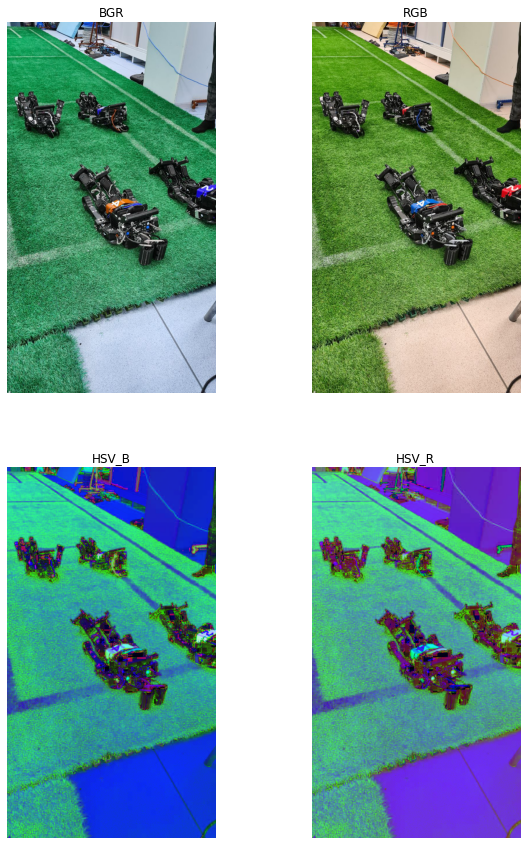

In [5]:
# Представление входных данных в других форматах
img_hsv_B = cv2.cvtColor(canvas,cv2.COLOR_BGR2HSV)
img_hsv_R = cv2.cvtColor(canvas,cv2.COLOR_RGB2HSV)
im_rgb = cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB)


plt.figure(figsize=(10, 15))

plt.subplot(221)
plt.imshow(canvas)
plt.axis('off')
plt.title('BGR')

plt.subplot(222)
plt.imshow(im_rgb)
plt.axis('off')
plt.title('RGB')

plt.subplot(223)
plt.imshow(img_hsv_B)
plt.axis('off')
plt.title('HSV_B')

plt.subplot(224)
plt.imshow(img_hsv_R)
plt.axis('off')
plt.title('HSV_R')

plt.show()

2. Настройте цветовой фильтр на лежащих на поле роботов. Скорее всего маска получится изрядно зашумленной. Удалите шум с помощью морфологических операций, выводя все промежуточные этапы на экран. Морфологических операций на самом деле много, рекомендуем к чтению документацию https://docs.opencv.org/4.x/d9/d61/tutorial_py_morphological_ops.html

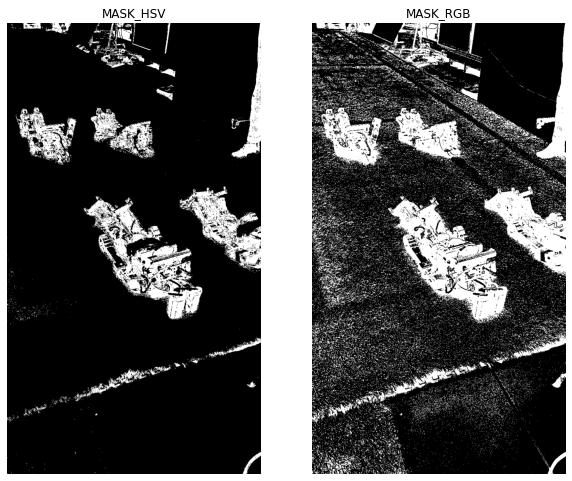

In [6]:
# Маскирование
mask = cv2.inRange(im_rgb, (45,99,9),(255,224,214))
mask_HSV = cv2.inRange(img_hsv_B, (0,0,0),(255,157,92))

# Маски  подготовка к отображению
negative_RGB_mask = 255-mask
plt.figure(figsize=(10, 15))

#1 - одна строка, 2 - два элемента, 2 - ставим элемент вторым в строке
plt.subplot(122)
plt.imshow(negative_RGB_mask,cmap='gray')
plt.axis('off')
plt.title('MASK_RGB')

plt.subplot(121)
plt.imshow(mask_HSV,cmap='gray')
plt.axis('off')
plt.title('MASK_HSV')

#Отображение
plt.show()

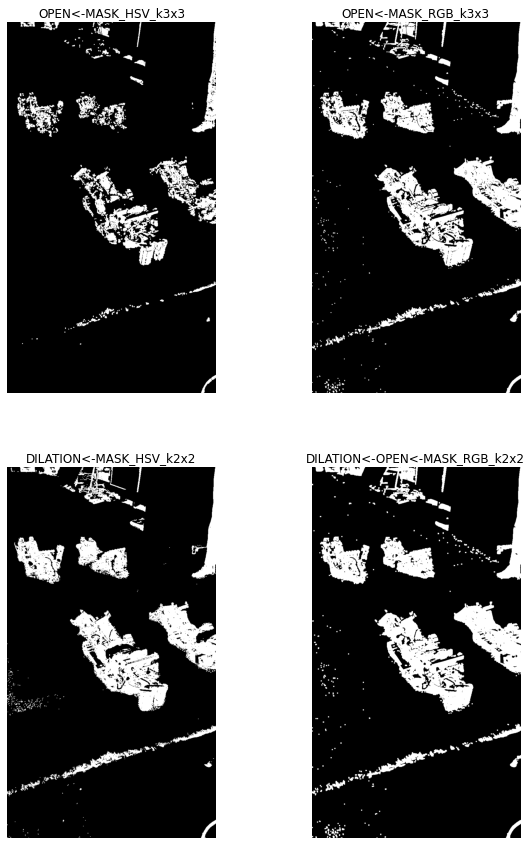

In [7]:
# Морфологические операции

# Ядро обработки маски
kernel = np.ones((3,3),np.uint8) 
#Операции открытия над полученными масками
opening_HSV = cv2.morphologyEx(mask_HSV, cv2.MORPH_OPEN,kernel)
opening_RGB = cv2.morphologyEx(negative_RGB_mask, cv2.MORPH_OPEN,kernel)

# Ядро обработки маски расширения
kernel_d = np.ones((2,2),np.uint8)

#Операция расширения над mask_HSV
dilation_HSV = cv2.dilate(mask_HSV,kernel_d,iterations = 1)

#Операция расширения над RGB маской после открытия
dilation_RGB = cv2.dilate(opening_RGB,kernel_d,iterations = 1)

#Морфологические операции подготовка к отображению

plt.figure(figsize=(10, 15))

plt.subplot(221)
plt.imshow(opening_HSV,cmap='gray')
plt.axis('off')
plt.title('OPEN<-MASK_HSV_k3x3')

plt.subplot(222)
plt.imshow(opening_RGB,cmap='gray')
plt.axis('off')
plt.title('OPEN<-MASK_RGB_k3x3')

plt.subplot(223)
plt.imshow(dilation_HSV,cmap='gray')
plt.axis('off')
plt.title('DILATION<-MASK_HSV_k2x2')

plt.subplot(224)
plt.imshow(dilation_RGB,cmap='gray')
plt.axis('off')
plt.title('DILATION<-OPEN<-MASK_RGB_k2x2')

#Отображение
plt.show()

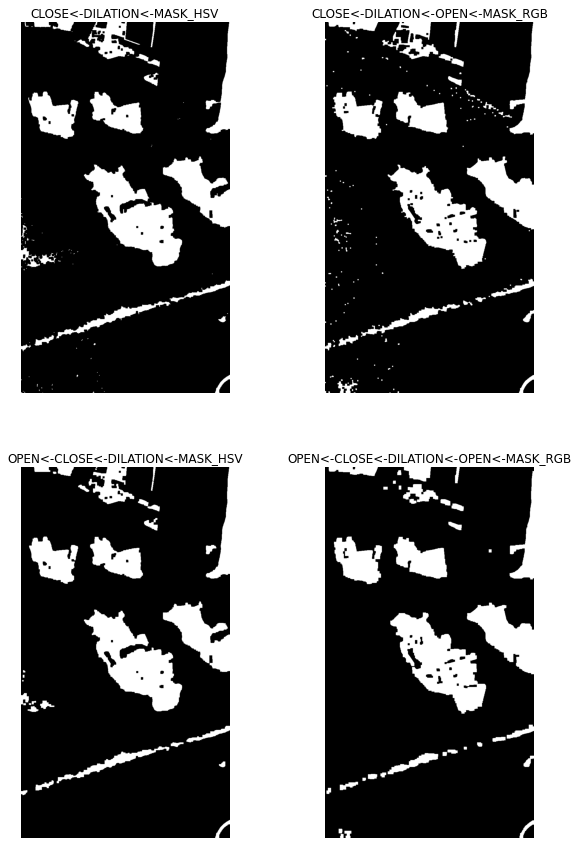

Достигнут не идеальный результат, можно было бы произвести еще пару итераций
но после испытания метода связных компонент нет смысла татить время!
Лучший результат при использовании обоих методов в связке!!!


In [8]:
# Морфологические операции


kernel = np.ones((7,7),np.uint8) # Ядро обработки маски
# Закрытие
closing_HSV = cv2.morphologyEx(dilation_HSV, cv2.MORPH_CLOSE, kernel)
closing_RGB = cv2.morphologyEx(dilation_RGB, cv2.MORPH_CLOSE, kernel)

#Открытие
opening_HSV = cv2.morphologyEx(closing_HSV, cv2.MORPH_OPEN,np.ones((5,5),np.uint8))
opening_RGB = cv2.morphologyEx(closing_RGB, cv2.MORPH_OPEN,np.ones((9,9),np.uint8))

#Морфологические операции подготовка к отображению

plt.figure(figsize=(10,15))

plt.subplot(221)
plt.imshow(closing_HSV,cmap='gray')
plt.axis('off')
plt.title('CLOSE<-DILATION<-MASK_HSV')

plt.subplot(222)
plt.imshow(closing_RGB,cmap='gray')
plt.axis('off')
plt.title('CLOSE<-DILATION<-OPEN<-MASK_RGB')

plt.subplot(223)
plt.imshow(opening_HSV,cmap='gray')
plt.axis('off')
plt.title('OPEN<-CLOSE<-DILATION<-MASK_HSV')

plt.subplot(224)
plt.imshow(opening_RGB,cmap='gray')
plt.axis('off')
plt.title('OPEN<-CLOSE<-DILATION<-OPEN<-MASK_RGB')

#Отображение
plt.show()
print("Достигнут не идеальный результат, можно было бы произвести еще пару итераций")
print("но после испытания метода связных компонент нет смысла татить время!")
print("Лучший результат при использовании обоих методов в связке!!!")

3. Удалите шум с помощью фильтрации связных компонент, пользуясь указаниями в первом ответе по ссылке https://stackoverflow.com/questions/35854197/how-to-use-opencvs-connectedcomponentswithstats-in-python

Размеры роботов на RGB маске 
15250
14528
25883
46607
Размеры роботов на HSV маске 
14107
12970
23395
44924


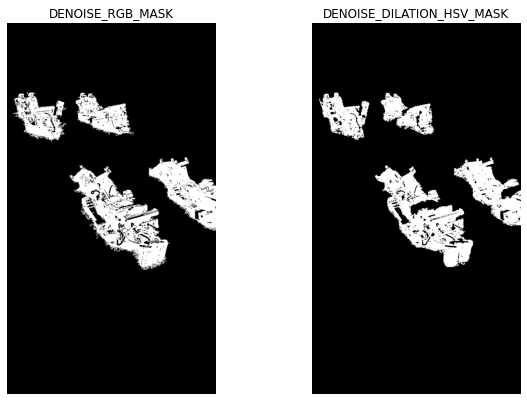

In [ ]:
#Метод связных компонент

def remove_small_components( img,min_size):
        # Находим все подключенные компоненты на изображении(белые пятна)
        nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(img, connectivity=8)
        # Функция connectedComponentswithStats выдает каждый отдельный компонент с информацией о каждом из них -размером например
        # Cледующая часть просто удаляет фон, который также считается компонентом
        sizes = stats[1:, -1]
        nb_components = nb_components - 1

        # your answer image
        img2 = img
        # для каждого компонента изображения сохраняем его, только если он больше min_size
        for i in range(0, nb_components):
            print(sizes[i])# Выводит размеры в px каждого компонента на изображении то есть размер области 50х50px выведется как 2500
            # Зрительно находим в выводе 4 объекта с самыми большими размерами и выставляем min_size, чтобы отсечь остальные
            # Как вариант можно программно отыскать 4 объекта с самыми большими размерами, а остальные удалить
            if sizes[i] < min_size:
                img2[output == i + 1] = 0

        return img2 


plt.figure(figsize=(10,15))

print("Размеры роботов на RGB маске ")
plt.subplot(221)
plt.imshow(remove_small_components(negative_RGB_mask,12000),cmap='gray')
plt.axis('off')
plt.title('DENOISE_RGB_MASK')

print("Размеры роботов на HSV маске ")
plt.subplot(222)
plt.imshow(remove_small_components(dilation_HSV,12000),cmap='gray')
plt.axis('off')
plt.title('DENOISE_DILATION_HSV_MASK')

#Отображение
plt.show()




In [ ]:
import cv2
import time
import math
%matplotlib inline
from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np

# Ищем пределы нижние и верхние для маскирования RGB изображения 
def f(rl, gl, bl, rh, gh, bh):
    mask = cv2.inRange(im_rgb, (rl, gl, bl),(rh, gh, bh))

    plt.figure (figsize=(8, 10))
    plt.imshow (mask,cmap='gray')
    plt.show ()
    plt.pause (0.05)
    plt.clf ()
 
interactive_plot = interactive(f, rl = (0, 255, 1), gl = (0, 255, 1), bl = (0, 255, 1),
                               rh = (0, 255, 1), gh = (0, 255, 1), bh = (0, 255, 1))
 
output = interactive_plot.children[-1]
output.layout.height = str (WIND_Y) + 'px'
output.layout.width = str (WIND_X) + 'px'
interactive_plot

interactive(children=(IntSlider(value=127, description='rl', max=255), IntSlider(value=127, description='gl', …